In [1]:
import sys
import os
import nibabel as nb
import numpy as np
import ext.neuron
import scipy
import lab2im
import matplotlib.pyplot as plt
basepath = os.getcwd()

Using TensorFlow backend.


(256, 256, 256)


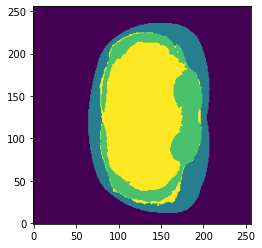

In [2]:
# classes and numbers: 0: background, 1: liver, 2: vasculature in liver, 3: fat, 4: spleen, 5: muscle, 6: lung, 7: general organs
# need to assign susceptibility values to these.
os.chdir(basepath)
#liver_means = np.array([[0, -6, -9, -7, -7.12, -7.38, 0, -9],
#                        [1,1,1,1,1,1,1,1]])
#liver_means = np.array([np.array([0, -6, -9, -7, -7.12, -7.38, 0, -9]),
#                        np.array([0,5,1,3,3,3,0,3])])
# Center around water (-9)
liver_means = np.array([np.array([9, 3, 0, 2, 1.88, 1.62, 9, 0]),
                        np.array([0,5,1,3,3,3,0,3])])
np.save('liver_means.npy',liver_means)
#liver_std = np.array([[0, -6, -9, -7, -7.12, -7.38, 0, -9],
#                      [1,1,1,1,1,1,1,1]])
liver_std = np.array([[0,0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0,0]])
np.save('liver_stds.npy',liver_std)
liver = nb.load('liver_all_parts_seg_20180410.nii.gz')
liver = np.array(liver.dataobj)
liver[:,:,0] = liver[:,:,1]
liver[:,:,255] = liver[:,:,254]
liver256 = liver[::2,::2,:]
print(liver256.shape)
liver_nii = nb.Nifti1Image(liver256, affine=np.eye(4))
nb.save(liver_nii,'liver_256_all_parts_seg_20180410.nii.gz')
plt.imshow(liver256[:,:,0],origin='lower')

# test generation labels
generation_labels = np.array([0,1,2,3,4,5,6,7])
np.save('generation_labels.npy',generation_labels)

In [3]:
import os
from lab2im.utils import save_volume
from lab2im.image_generator import ImageGenerator

os.chdir(basepath)
# label map to generate images from
path_label_map = './liver_256_all_parts_seg_20180410.nii.gz'

# general parameters
n_examples = 100
n_eval = 20
result_dir = '/raid/generated_images_110320'
output_shape = None  # shape of the output images, obtained by randomly cropping the generated images

prior_distribution = 'normal'
prior_means = './liver_means.npy'
prior_stds = './liver_stds.npy'
generation_labels = './generation_labels.npy'

liver_generator = ImageGenerator(labels_dir = path_label_map,
                                 generation_labels=generation_labels,
                                 prior_distributions=prior_distribution,
                                 prior_means=prior_means,
                                 prior_stds=prior_stds,
                                 )

# create result dir
if not os.path.exists(os.path.join(result_dir)):
    os.mkdir(result_dir)
train_dir = os.path.join(result_dir,'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

for n in range(n_examples):

    # generate new image and corresponding labels
    im, lab = liver_generator.generate_image()
    # save output image and label map
    save_volume(im, liver_generator.aff, liver_generator.header, os.path.join(train_dir, 'chi_%s.nii.gz' % n))
    save_volume(lab, liver_generator.aff, liver_generator.header, os.path.join(train_dir, 'chi_labels_%s.nii.gz' % n))
    
eval_dir = os.path.join(result_dir,'eval')
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir)
    
for n in range(n_eval):

    # generate new image and corresponding labels
    im, lab = liver_generator.generate_image()
    # save output image and label map
    save_volume(im, liver_generator.aff, liver_generator.header, os.path.join(eval_dir, 'chi_%s.nii.gz' % n))
    save_volume(lab, liver_generator.aff, liver_generator.header, os.path.join(eval_dir, 'chi_labels_%s.nii.gz' % n))

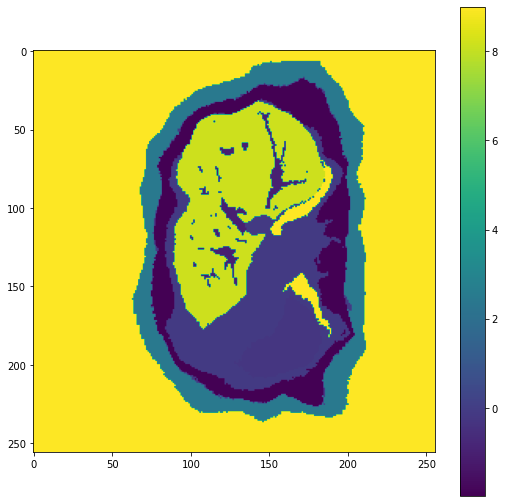

In [17]:
liver = nb.load('/raid/generated_images_110320/train/chi_7.nii.gz')
liver = np.array(liver.dataobj)
plt.figure(figsize=[9,9])
plt.imshow(liver[:,:,160])
plt.colorbar()

In [27]:
print(np.load('./tutorials/data_example/generation_labels.npy'))

[  0  14  15  16  24  72  85 165 258 259   2   3   4   5   7   8  10  11
  12  13  17  18  26  28  30  31]
